![title](../static/wcar.png)

    Michele Tinti
    Wellcome Centre for Anti-Infectives Research
    School of Life Sciences, University of Dundee

# Analysis

## set up code

In [48]:
#reload when modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
%run ../mylib/imports.py 

In [50]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [51]:
from mylib import utilities

## Load dataset

In [52]:
df = pd.read_csv('iRNAvivo_count_all.txt',sep='\t')
df.columns =['Gene','E1','E2','E3','C1','R1','R2']
df.head()

,Gene,E1,E2,E3,C1,R1,R2
0,Tb10.v4.0073,191,249,131,209,71,91
1,Tb10.v4.0074,39,97,78,452,22,19
2,Tb10.v4.0075,81,68,128,572,139,196
3,Tb10.v4.0076,158,43,18,140,53,62
4,Tb10.v4.0077,493,163,192,260,53,61


## QC

## Library size

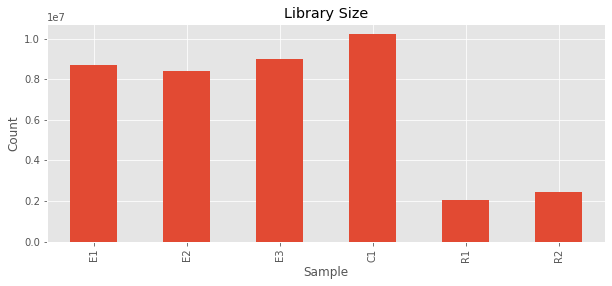

In [55]:
fig,ax=plt.subplots(figsize=(10,4))
df.iloc[:,1:].sum(axis=0).plot(kind='bar',ax=ax)
plt.title('Library Size')
plt.ylabel('Count')
plt.xlabel('Sample')
plt.show()

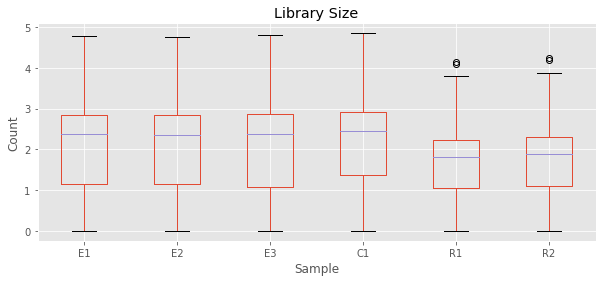

In [56]:
fig,ax=plt.subplots(figsize=(10,4))
np.log10(df.iloc[:,1:]).plot(kind='box',ax=ax)
plt.title('Library Size')
plt.ylabel('Count')
plt.xlabel('Sample')
plt.show()

## Missing Data

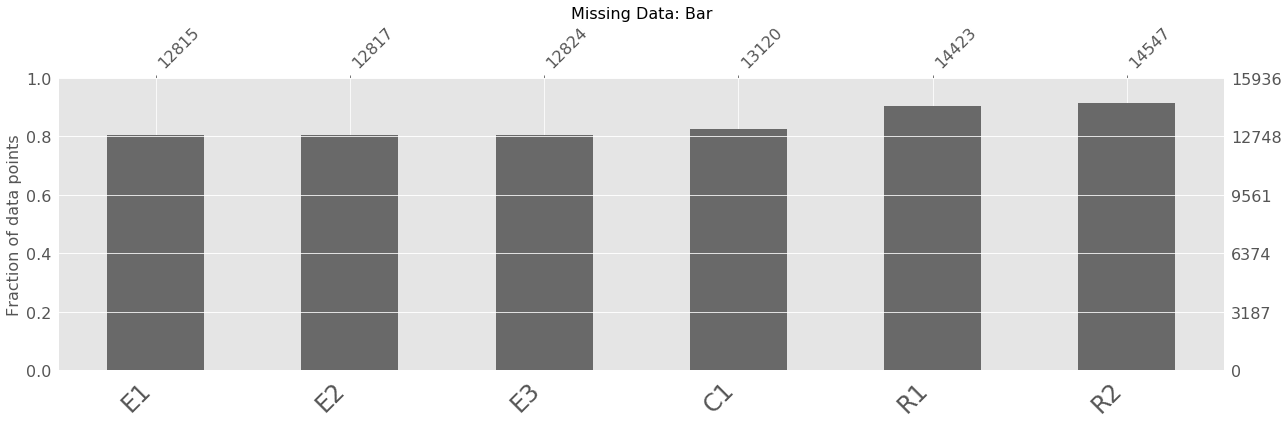

In [58]:
import missingno as msno
#visualization of missing data
ax=msno.bar(df.iloc[:,1:].replace(0,np.nan),figsize=(18, 6))
plt.title('Missing Data: Bar',size=16)
ax.set_ylabel('Fraction of data points',size=16)
plt.xticks(fontsize=16)#, rotation=90)
#ax.xaxis.set_tick_params(labelsize=8,bottom=True)
ax.xaxis.set_tick_params(labelsize=24,top=True)
plt.tight_layout()
plt.show()

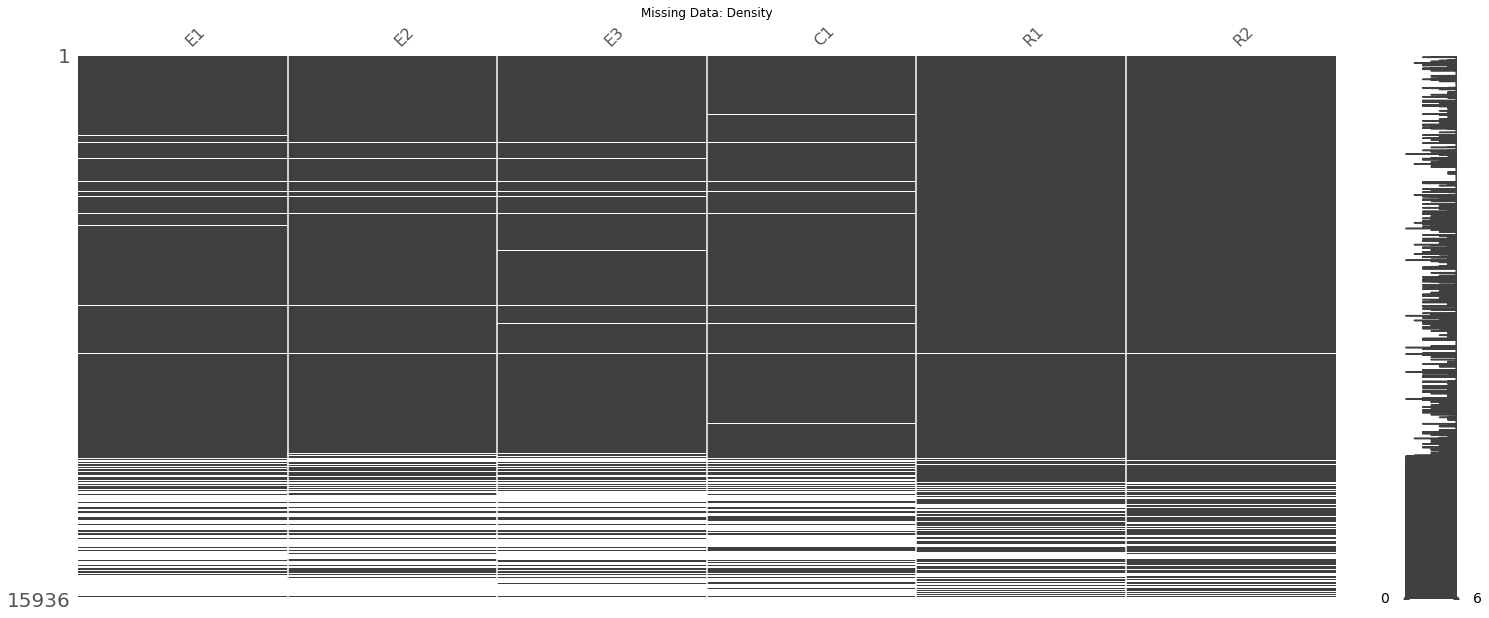

In [59]:
msno.matrix(df.iloc[:,1:].replace(0,np.nan))
plt.title('Missing Data: Density',size=12)
plt.show()

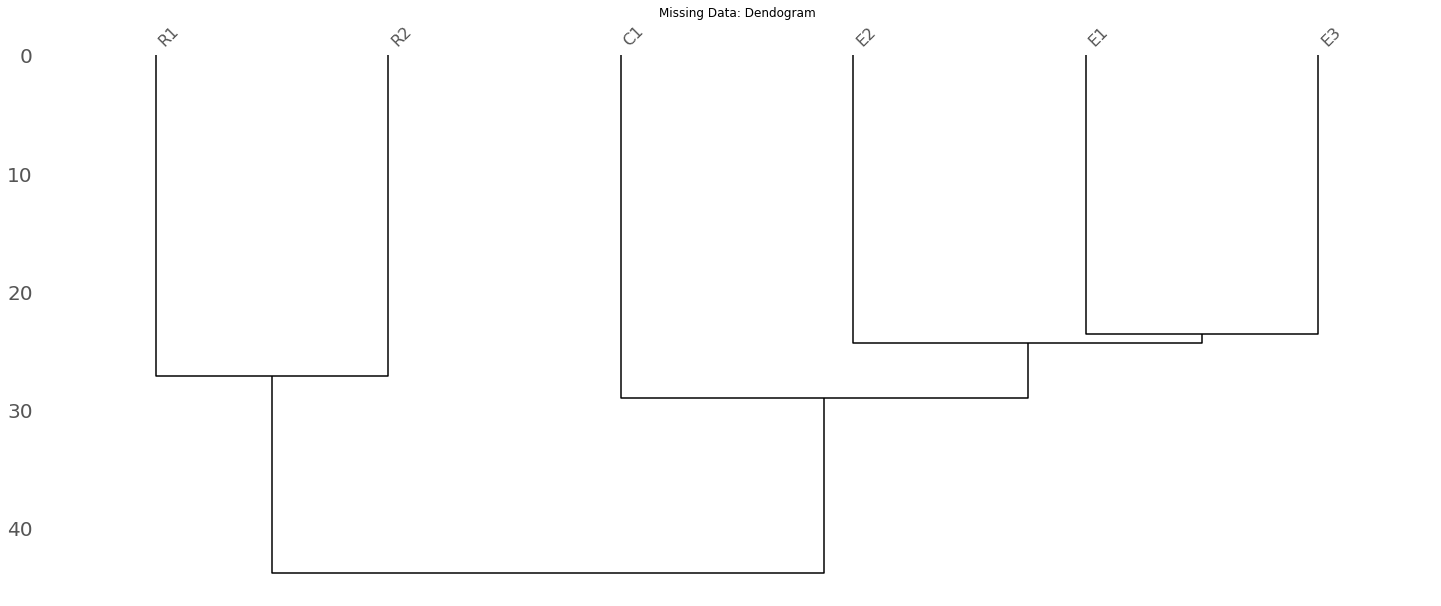

In [60]:
msno.dendrogram(df.iloc[:,1:].replace(0,np.nan))
plt.title('Missing Data: Dendogram',size=12)
plt.show()

## Values Distribution

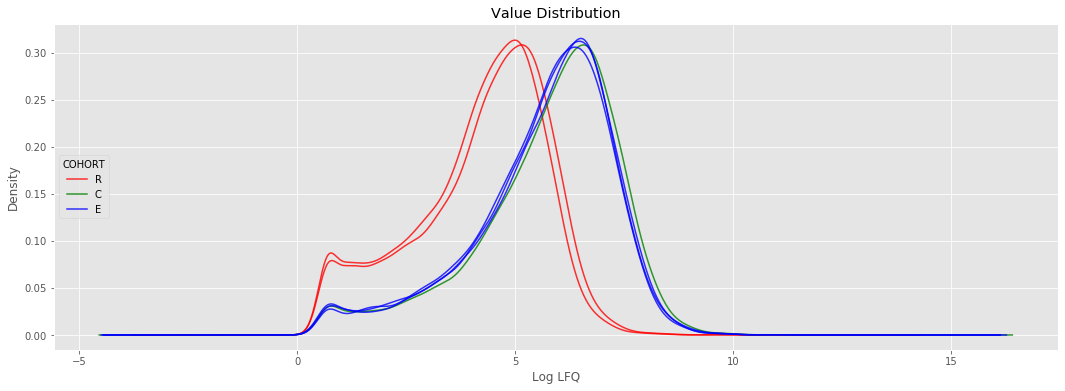

In [93]:
#selection=selection.replace(0, np.nan)
selection=df.iloc[:,1:].replace(0,np.nan)
color_dictionary = {'R': 'r', 'C': 'g', 'E': 'b'}
colors = [color_dictionary[n[0]] for n in selection.columns]

fig,ax=plt.subplots(figsize=(18, 6))
np.log1p(selection[[n for n in selection.columns if 'R' in n]]).plot(kind='kde',
                                                                             c='r',alpha=0.8,
                                                                             label='R',ax=ax)
np.log1p(selection[[n for n in selection.columns if 'C' in n]]).plot(kind='kde',
                                                                                  c='g',alpha=0.8,
                                                                                  label='C',ax=ax)
np.log1p(selection[[n for n in selection.columns if 'E' in n]]).plot(kind='kde',
                                                                            c='b',alpha=0.8,
                                                                              label='E',ax=ax)

handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[0],
               handles[2],
               handles[-1]]
#new_handles[0].set_alpha(1)
#new_handles[1].set_alpha(1)
#new_handles[2].set_alpha(1)
new_labels = ['R','C','E']
ax.legend(handles=new_handles, labels=new_labels, title='COHORT',loc='center left')#bbox_to_anchor=(1, 0.5))  

#plt.xlim(15,26)
plt.title('Value Distribution')
plt.xlabel('Log LFQ')
plt.show()

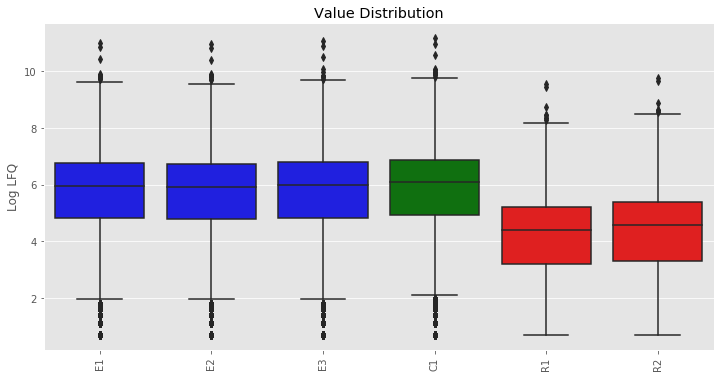

In [62]:
fig,ax=plt.subplots(figsize=(12, 6))
chart=sns.boxplot( data=np.log1p(selection), palette=colors,ax=ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Value Distribution')
plt.ylabel('Log LFQ')
plt.show()

## Dimensionality reduction MDS

{'r': 'R', 'g': 'C', 'b': 'E'}


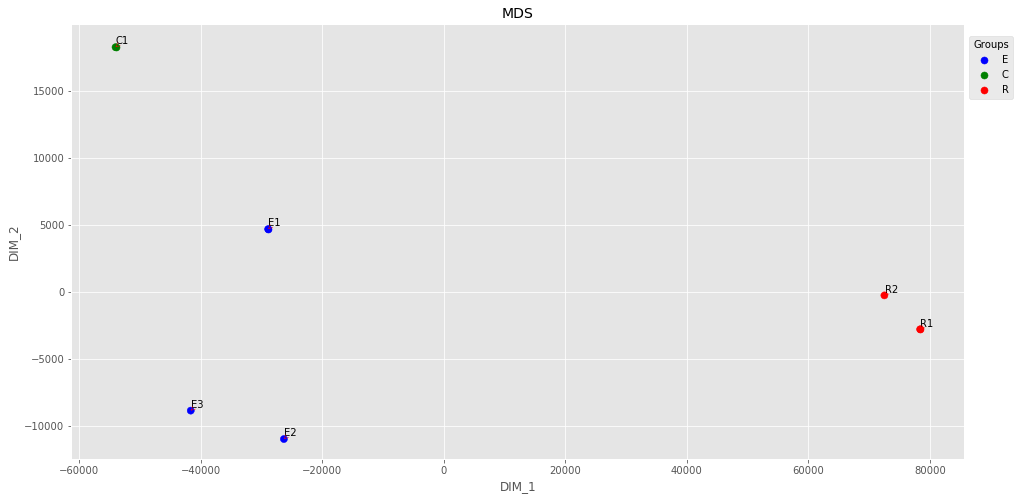

In [63]:
colors = [color_dictionary[n[0]] for n in selection.columns]
fig, ax = plt.subplots(figsize=(16,8))
temp = selection.copy()
temp.columns = [n.split('_')[-1] for n in temp.columns]
utilities.make_mds(temp.dropna(), 
                   colors, ax, top=500, 
                   color_dictionary=dict((v,k) for k,v in color_dictionary.items()),
                   do_adjust_text=True)
#plt.legend()

## Run edgeR

In [64]:
counts = df[['E1','E2','E3','C1','R1','R2']]
#counts = df[['E1','E2','E3','R1','R2']]

In [65]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [66]:
%%R -i counts
options(warn=0)
library("limma") 
library("edgeR")
library("DESeq2")

In [68]:
%R head(counts)

,E1,E2,E3,C1,R1,R2
0,191,249,131,209,71,91
1,39,97,78,452,22,19
2,81,68,128,572,139,196
3,158,43,18,140,53,62
4,493,163,192,260,53,61
5,0,0,0,226,34,28


In [69]:
%%R 
group <- factor(c(1,1,1,2,3,3))
y <- DGEList(counts=counts, group=group)
y <- calcNormFactors(y)
design <- model.matrix(~group)
design

  (Intercept) group2 group3
1           1      0      0
2           1      0      0
3           1      0      0
4           1      1      0
5           1      0      1
6           1      0      1
attr(,"assign")
[1] 0 1 1
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"



In [70]:
%%R 
y <- estimateDisp(y, design)
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit, coef=3)
res_table <- qlf$table
pseudo_counts = qlf$fitted.values
topTags(qlf)

Coefficient:  group3 
          logFC   logCPM        F       PValue          FDR
9325  -3.762199 8.945920 935.6793 1.057897e-08 0.0001127769
10579 -2.750716 9.388982 778.8191 1.999025e-08 0.0001127769
1612  -3.016763 8.687107 659.8526 3.549302e-08 0.0001127769
6327   4.269456 7.642137 653.5373 3.669414e-08 0.0001127769
10578 -2.644478 9.347326 649.5764 3.747422e-08 0.0001127769
7149   4.291940 8.048017 626.5374 4.246117e-08 0.0001127769
3094  -2.559172 8.933266 564.8451 6.076181e-08 0.0001222033
6517  -2.498687 9.027183 563.2803 6.134703e-08 0.0001222033
10986 -3.728192 8.205508 491.1817 9.843804e-08 0.0001743010
6242   2.717469 7.899121 454.0156 1.291183e-07 0.0002057629


In [71]:
%R head(res_table)

,logFC,logCPM,F,PValue
0,0.616870,4.720665,2.111382,0.189598
1,0.075582,3.935158,0.018065,0.896872
2,2.718016,5.264484,53.908755,0.000158
3,1.519752,3.880946,3.163955,0.118592
4,-0.438796,4.879651,0.619192,0.457204
5,9.496474,3.043431,100.902145,0.000170


## Grab edgeR results

In [74]:
%R -o res_table

In [75]:
%R -o pseudo_counts

In [76]:
pseudo_counts = pd.DataFrame(pseudo_counts)
pseudo_counts.columns =['pE1','pE2','pE3','pC1','pR1','pR2']

,pE1,pE2,pE3,pC1,pR1,pR2
0,193.115702,185.079480,196.662120,209.0,73.525405,88.008768
1,72.251579,69.244937,73.578422,452.0,18.899301,22.622170
2,92.585521,88.732713,94.285781,572.0,151.419446,181.246726
3,73.517386,70.458069,74.867474,140.0,52.395577,62.716692
4,283.892339,272.078582,289.105797,260.0,51.972524,62.210304


In [77]:
res_table.shape,df.shape,pseudo_counts.shape

((15936, 4), (15936, 7), (15936, 6))

In [78]:
res_table.index = [int(n) for n in res_table.index]

In [79]:
merge = pd.concat([df, pseudo_counts, res_table], axis=1)
merge['minusLog10p']=-np.log10(merge['PValue'])
df.shape

(15936, 7)

In [111]:
merge['mean_pE'] = merge[['pE1','pE2','pE3']].mean(axis=1)
merge['mean_pR'] = merge[['pR1','pR2']].mean(axis=1)
merge['log2FC_pR_pC'] = np.log2(merge['mean_pR']/(merge['pC1']+1))
merge.head()

,Gene,E1,E2,E3,C1,R1,R2,pE1,pE2,pE3,...,pR1,pR2,logFC,logCPM,F,PValue,minusLog10p,mean_pE,mean_pR,log2FC_pR_pC
0,Tb10.v4.0073,191,249,131,209,71,91,193.115702,185.079480,196.662120,...,73.525405,88.008768,0.616870,4.720665,2.111382,0.189598,0.722166,191.619101,80.767086,-1.378550
1,Tb10.v4.0074,39,97,78,452,22,19,72.251579,69.244937,73.578422,...,18.899301,22.622170,0.075582,3.935158,0.018065,0.896872,0.047269,71.691646,20.760736,-4.447582
2,Tb10.v4.0075,81,68,128,572,139,196,92.585521,88.732713,94.285781,...,151.419446,181.246726,2.718016,5.264484,53.908755,0.000158,3.800155,91.868005,166.333086,-1.784460
3,Tb10.v4.0076,158,43,18,140,53,62,73.517386,70.458069,74.867474,...,52.395577,62.716692,1.519752,3.880946,3.163955,0.118592,0.925943,72.947643,57.556134,-1.292654
4,Tb10.v4.0077,493,163,192,260,53,61,283.892339,272.078582,289.105797,...,51.972524,62.210304,-0.438796,4.879651,0.619192,0.457204,0.339890,281.692239,57.091414,-2.192704


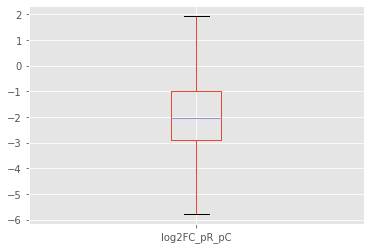

In [123]:
merge['log2FC_pR_pC'].plot(kind='box', showfliers=False)
plt.show()

## pValues visualization

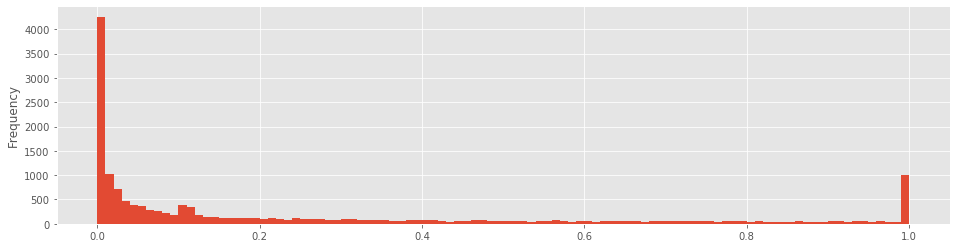

In [115]:
merge.PValue.plot(kind='hist', bins=100,figsize=(16,4))
#plt.savefig(os.path.join(TXT_PATH,'Fig_S4_pval.png'))
plt.show()

## Volcano Plot

8
['Tb11.1190' 'Tb927.11.9220' 'Tb927.4.3810' 'Tb927.6.1290' 'Tb427VSG-1065'
 'Tb927.11.10160' 'Tb927.8.3150' 'Tb927.3.3270']


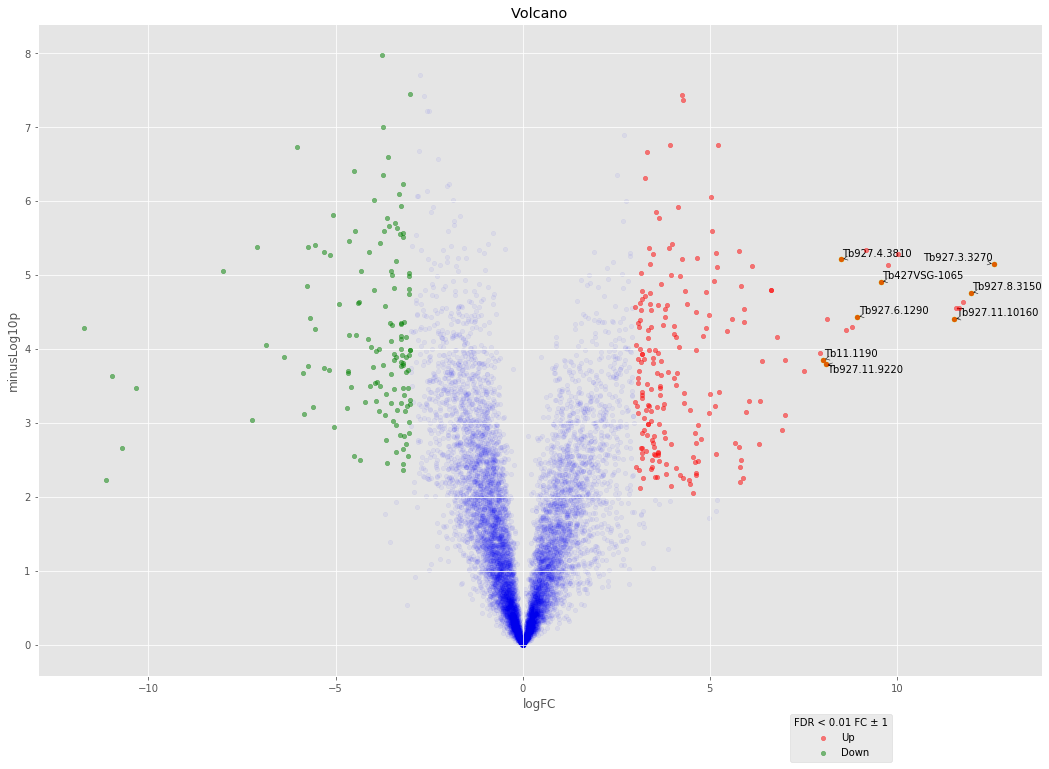

In [118]:
#temp = merge.sort_values('PValue').head()
temp = merge[merge['PValue']<0.01]
temp = temp[temp['logCPM']>4]
temp = temp[temp['log2FC_pR_pC']>5]
temp=temp.sort_values(by='logFC').tail(8)
_ids = temp.index.values
_names = temp.Gene.values
print(len(_names))
print(_names)

fig,ax=plt.subplots(figsize=(18,12), ncols=1, nrows=1)

utilities.make_vulcano(merge[(merge['logCPM']>4)], ax, x='logFC',
                       y='minusLog10p', annot_index=_ids,
                       annot_names =_names, title='Volcano',
                       pval_col='PValue', pval_limit=0.01,
                       fc_col='logFC',
                       fc_limit=3,
                       legend_title='FDR < 0.01 FC ± 1')


In [121]:
temp[temp['Gene'].isin(['Tb427VSG-1065'])]

,Gene,E1,E2,E3,C1,R1,R2,pE1,pE2,pE3,...,pR1,pR2,logFC,logCPM,F,PValue,minusLog10p,mean_pE,mean_pR,log2FC_pR_pC
12332,Tb427VSG-1065,0,2,0,3,159,187,0.67489,0.646806,0.687284,...,157.609767,188.656443,9.570123,4.569524,118.74804,0.000012,4.910868,0.66966,173.133105,5.435738


## Selected Genes Visualization

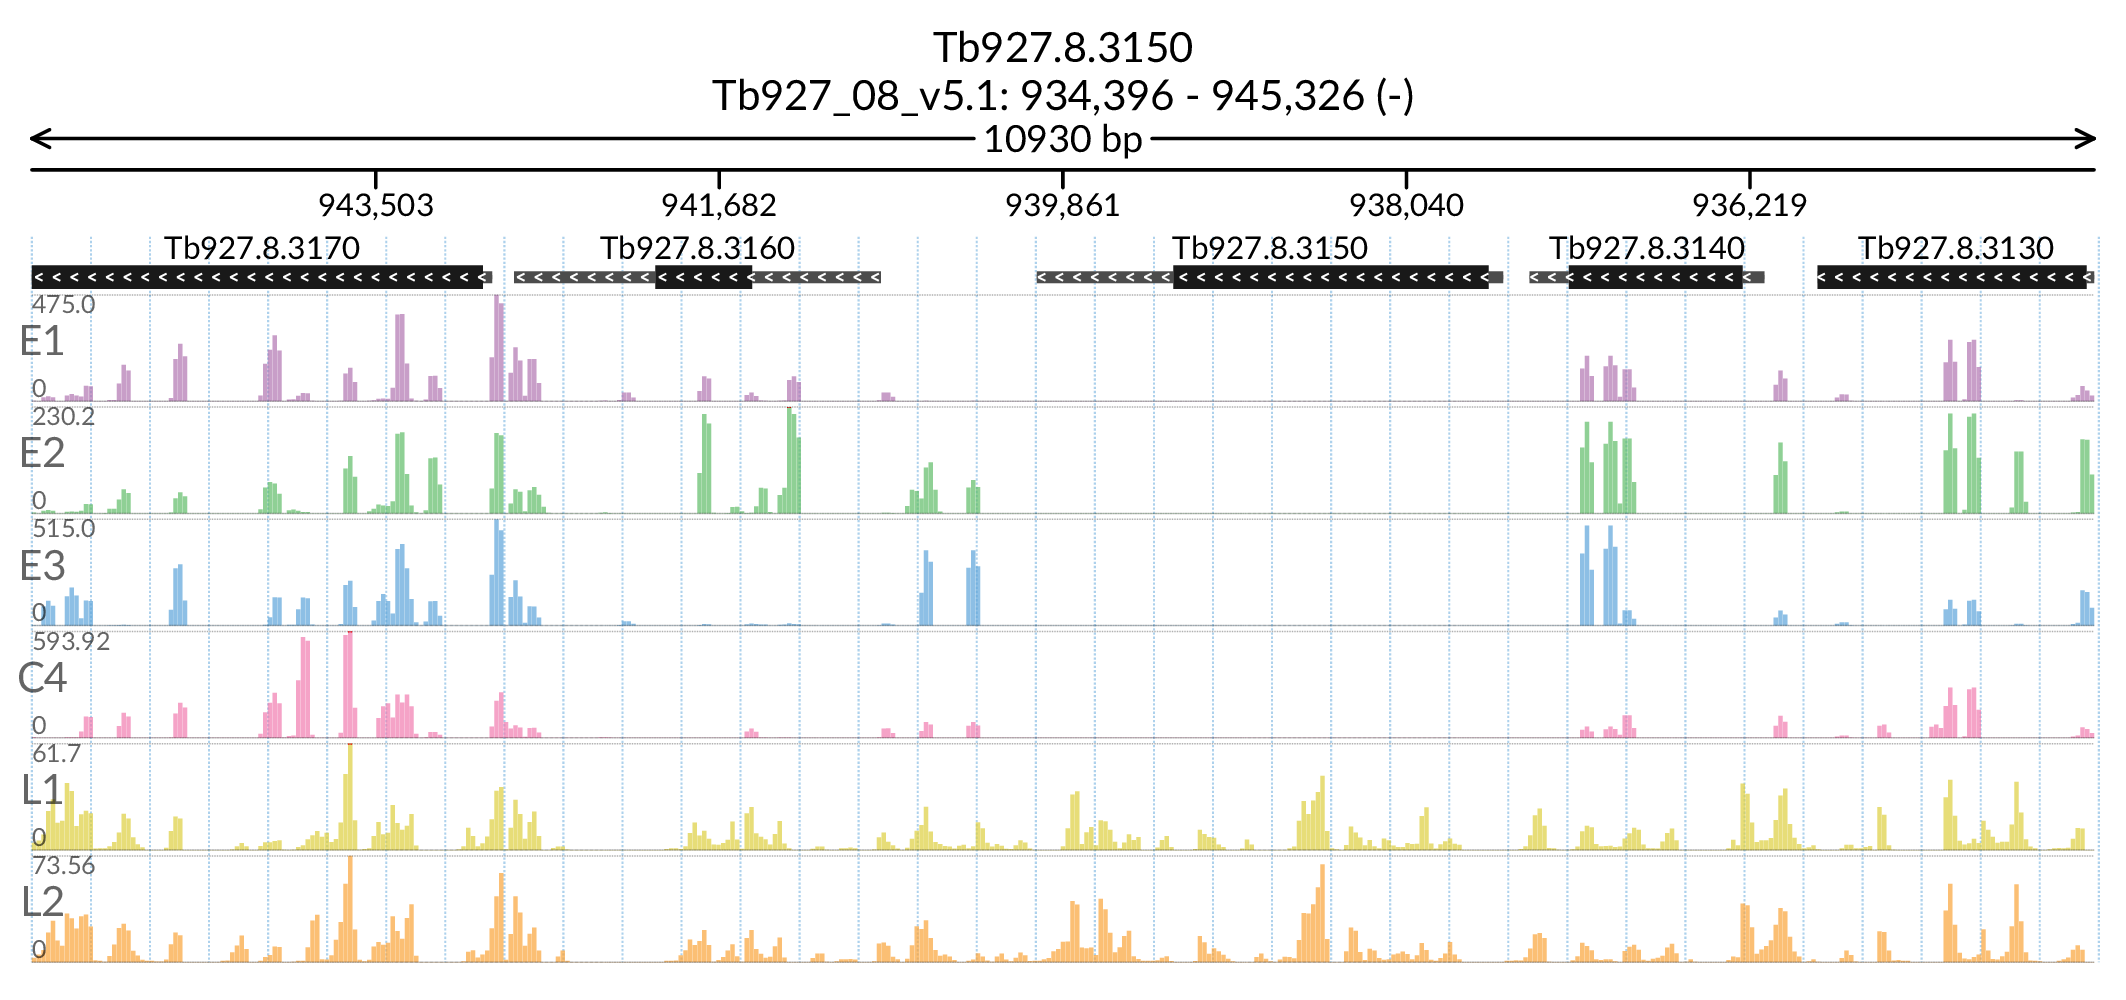

In [46]:
from IPython.display import Image
Image(filename='../Tb927.8.3150.png')

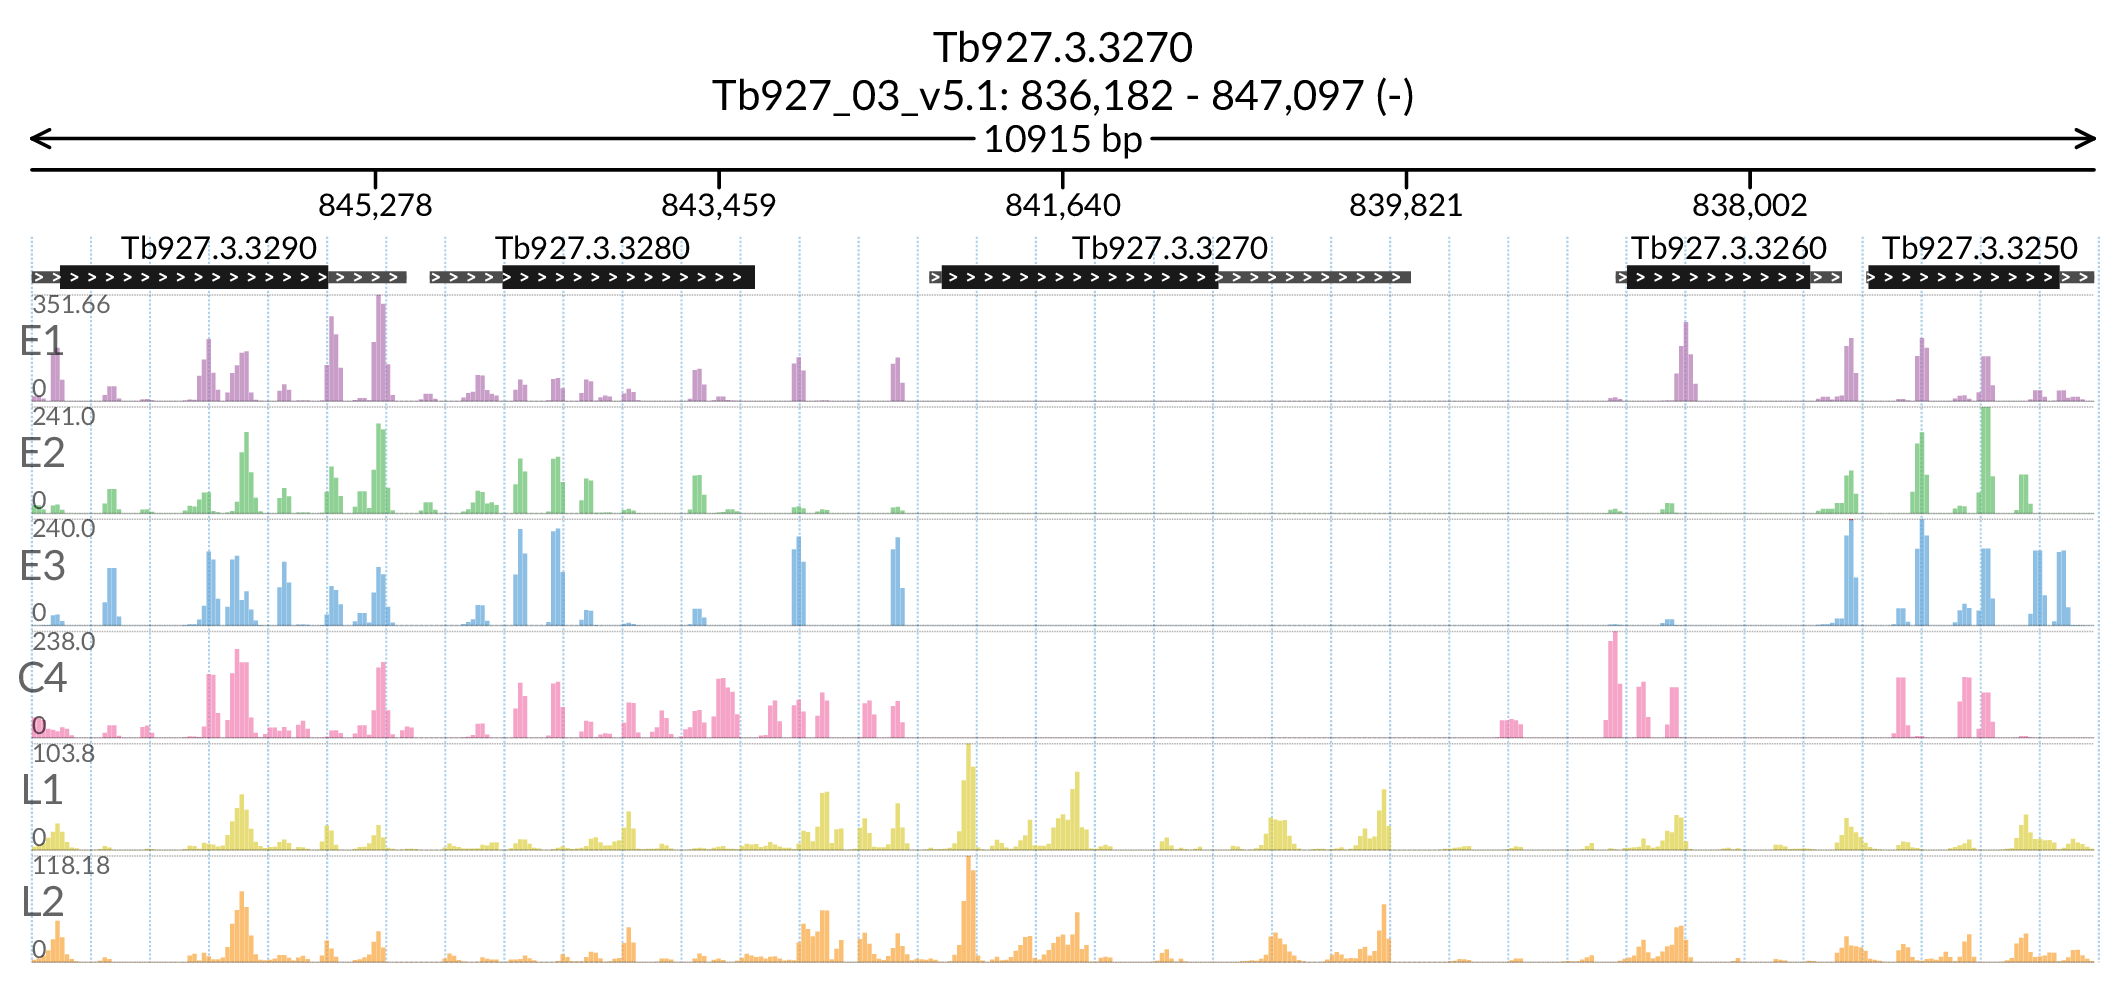

In [47]:
from IPython.display import Image
Image(filename='../Tb927.3.3270.png')

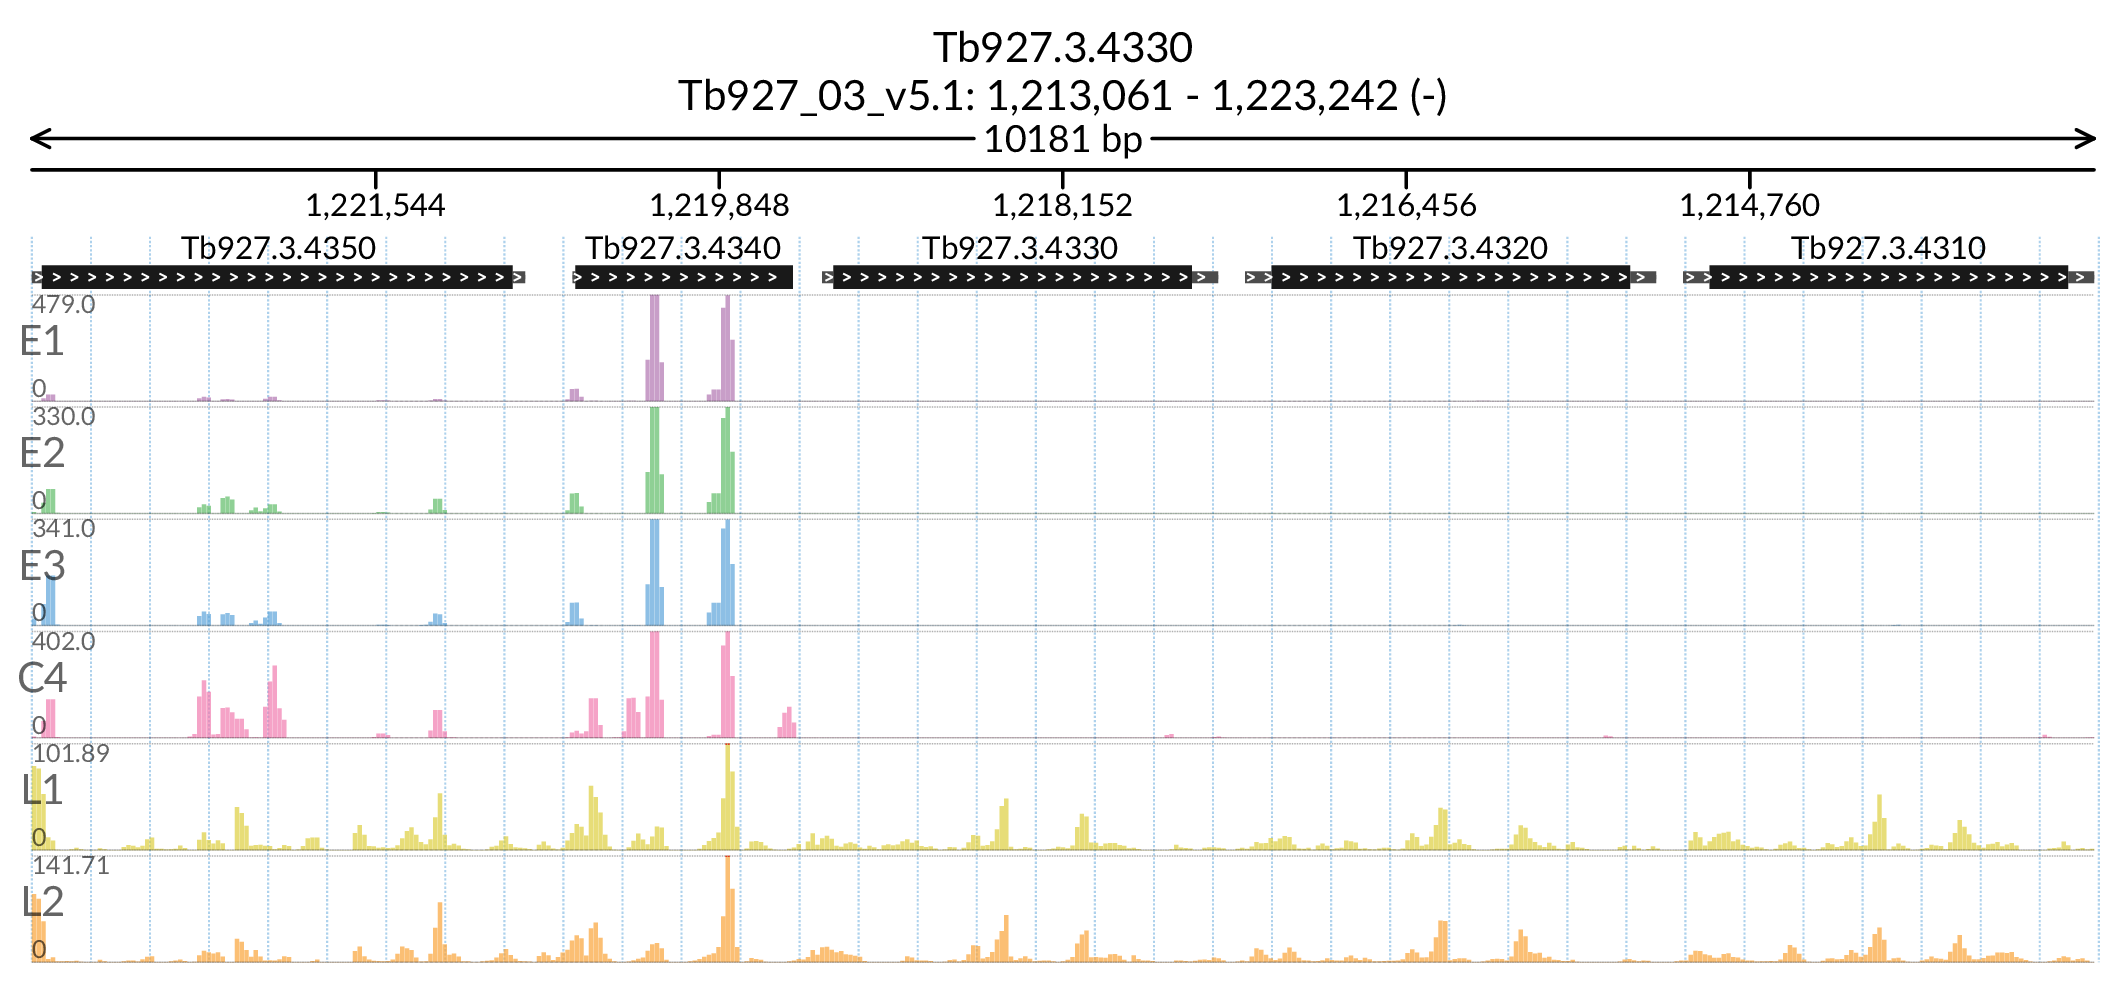

In [88]:
from IPython.display import Image
Image(filename='../Tb927.3.4330.png')

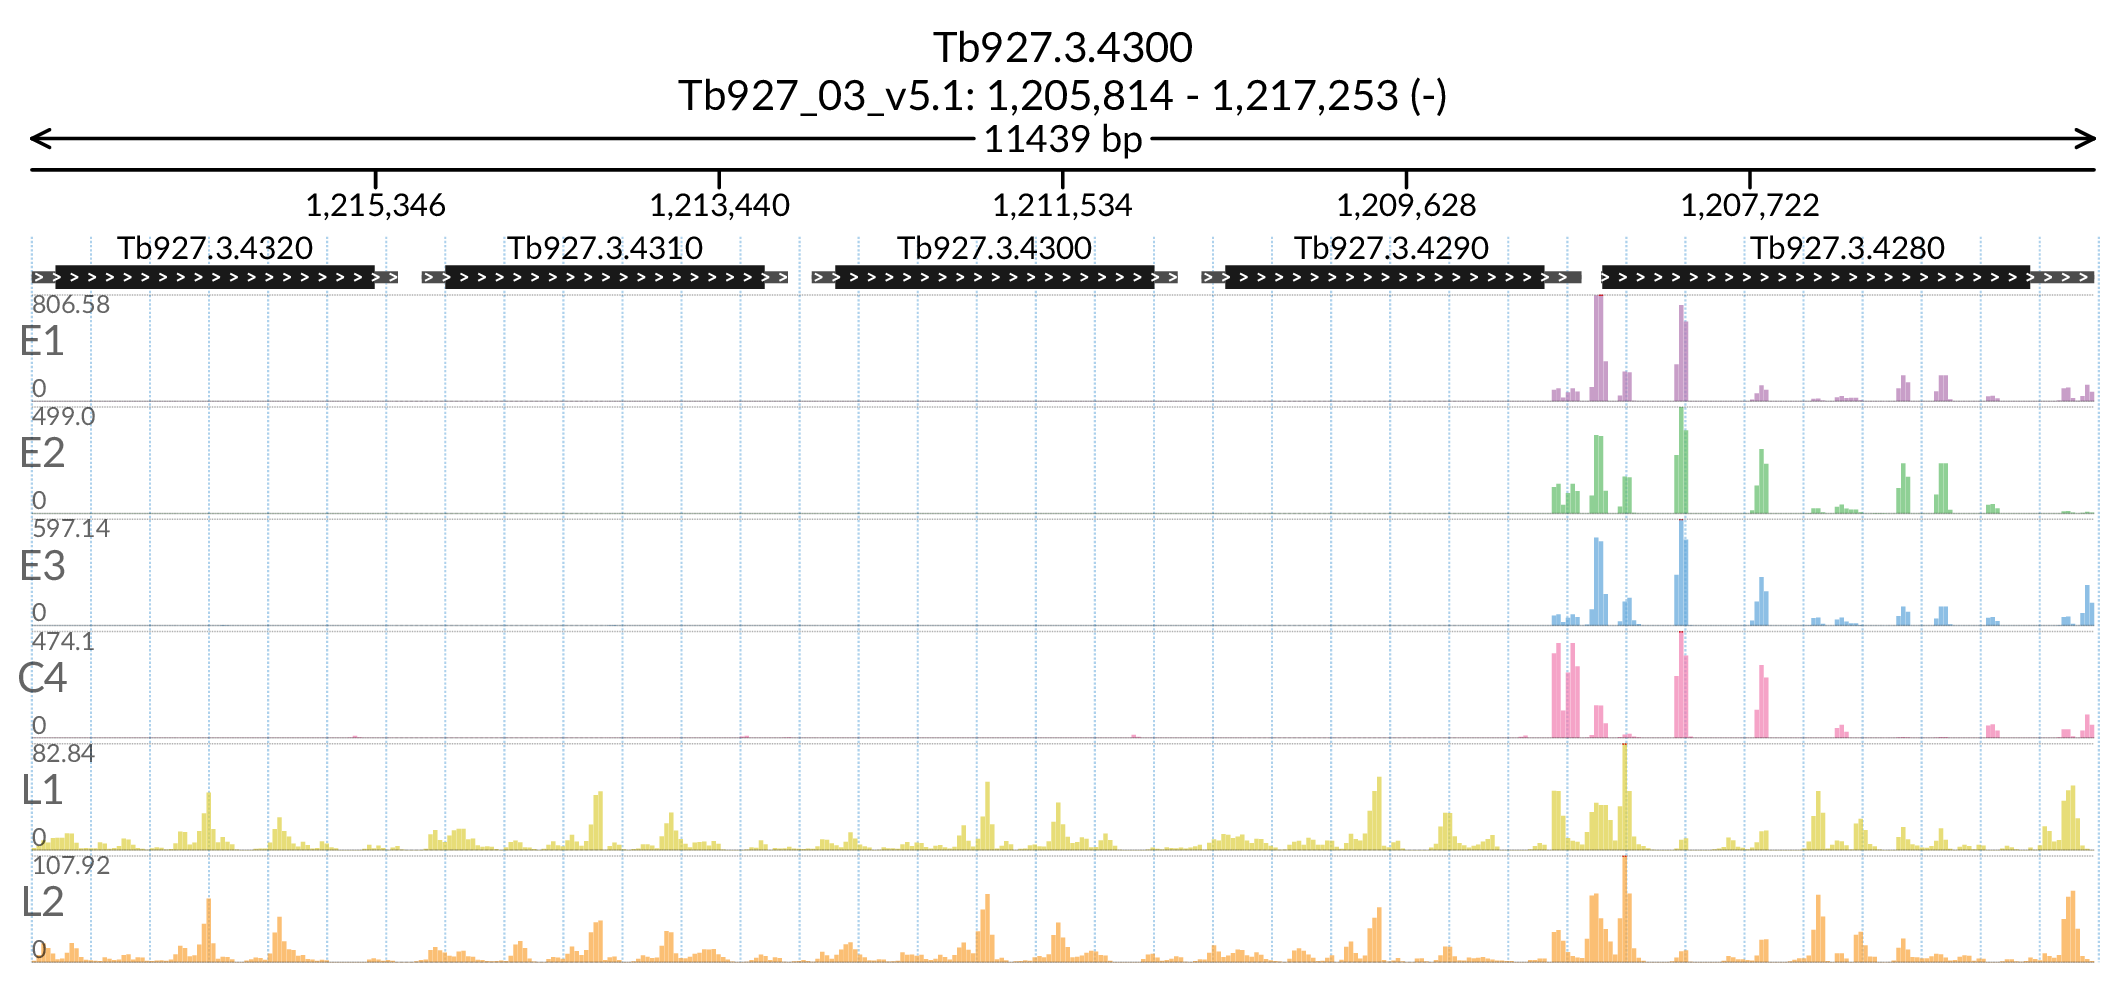

In [89]:
from IPython.display import Image
Image(filename='../Tb927.3.4300.png')

In [90]:
!jupyter nbconvert --to html analysis.ipynb

[NbConvertApp] Converting notebook analysis.ipynb to html
[NbConvertApp] Writing 1487153 bytes to analysis.html


In [91]:
!jupyter nbconvert analysis.ipynb --template toc2

[NbConvertApp] Converting notebook analysis.ipynb to html
[NbConvertApp] Writing 1489422 bytes to analysis.html
